<a href="https://colab.research.google.com/github/NicholasTYD/CS5284_Project/blob/main/CS5284_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    !pip install transformers
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    # path_to_file = '/content/gdrive/My Drive/CS5284_2025_codes/codes/07_Shallow_Learning'
    # print(path_to_file)
    # change current path to the folder containing "path_to_file"
    # os.chdir(path_to_file)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import itertools
import re
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans

In [3]:
if 'google.colab' in sys.modules:
    # Configs - Google Drive
    data_path = "/content/drive/MyDrive/CS Masters/CS5284/Big-Data-Analysis-Master.xlsx" # Change this to google drive file
    sheets_for_comparison = ["Raw - By device platform", "Raw - By Age Gender"]
else:
    # Configs - Local
    data_path = "data/input/Big-Data-Analysis-Master.xlsx"
    sheets_for_comparison = ["Raw - By device platform", "Raw - By Age Gender"]

# Modeling controls
test_size = 0.2
seed = 777
min_label_count = 50
np.random.seed(seed)


In [4]:
raw_df = pd.read_excel(data_path, sheet_name=sheets_for_comparison[0])

In [5]:
print("Raw Dataset Info:")
display(raw_df.describe())
with pd.option_context('display.max_columns', 999):
  print("NaN Counts:")
  display(pd.DataFrame(raw_df.isna().sum()).T) # Transpose so that the results are displayed as a row instead of a long column - Just a visual thing.

Raw Dataset Info:


,Campaign ID,Ad set ID,Ad ID,Amount spent,"CPM (cost per 1,000 impressions)",Reach,Impressions,Clicks (all),Leads,Cost per Lead,Meta leads,Local Language,Event,Exclusivity,Rental,Returns,Discounts,Frequency
count,9.748000e+03,9.748000e+03,9.748000e+03,9707.000000,9707.000000,9717.000000,9748.000000,6147.000000,1995.000000,1995.000000,1994.000000,1504.000000,7753.000000,3730.000000,1258.000000,1322.000000,906.000000,9717.000000
mean,9.870300e+16,9.976067e+16,1.001561e+17,67.729795,87.294686,1332.129670,2433.045958,36.779730,3.034085,85.642074,3.032598,0.457447,0.894750,0.781233,0.351351,0.382753,0.099338,1.348687
std,4.012533e+16,3.940175e+16,3.912055e+16,170.255334,453.896412,5128.060809,10516.935740,125.291756,4.009372,79.525915,4.006322,0.498352,0.306895,0.413465,0.477582,0.486243,0.299280,0.366534
min,2.385300e+16,2.385300e+16,2.385301e+16,0.009982,0.087637,1.000000,1.000000,1.000000,1.000000,0.152887,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,1.202015e+17,1.202017e+17,1.202020e+17,2.021496,29.762545,31.000000,36.000000,2.000000,1.000000,34.360000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.121951
50%,1.202113e+17,1.202113e+17,1.202114e+17,13.638393,48.564815,176.000000,219.500000,7.000000,1.000000,64.301469,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.260870
75%,1.202160e+17,1.202160e+17,1.202160e+17,59.863725,78.508722,789.000000,1073.000000,25.000000,3.000000,112.034886,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.465767
max,1.202196e+17,1.202199e+17,1.202199e+17,2995.957520,35730.000000,345151.000000,625812.000000,6647.000000,56.000000,1319.640057,56.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.750000


NaN Counts:


,Campaign ID,Ad set ID,Included custom audiences,Excluded custom audiences,Custom Audience Defined,Exclusion Defined,Ad ID,Campaign-Adset-Ad,Ads,Month,Device platform,Platform,Currency,Amount spent,"CPM (cost per 1,000 impressions)",Reach,Impressions,Clicks (all),Leads,Cost per Lead,Meta leads,Objective,headline,Local Language,Event,Exclusivity,Rental,Returns,Discounts,Frequency,Reporting starts,Reporting ends
0,0,0,7891,2942,0,0,0,0,0,0,0,0,0,41,41,31,0,3601,7753,7753,7754,0,816,8244,1995,6018,8490,8426,8842,31,0,0


## Data Preprocessing

In [6]:
platform_df = raw_df.copy()
# age_gender_df = pd.read_excel(data_path, sheet_name=sheets_for_comparison[1])

In [7]:
def clean_platform_data(df):
  """
  For 'Raw - By device platform' sheet
  - Drops all missing CPL entries
  - Removes rows with 'unknown' platform or device platform.
  - Removes rows with missing 'Frequency'.
  - Fills missing values in object and numeric columns.
  - Converts 'Amount spent', 'CPM', and 'Cost per Lead' from MYR to SGD.
  - Renames 'CPM (cost per 1,000 impressions)' to 'CPM' and 'Clicks (all)' to 'Clicks'.
  """
  df = df.copy()

  # Drop all missing CPL lines
  df = df.dropna(subset=['Cost per Lead'])

  # normalize strings
  for c in ["Platform","Device platform","Currency","Objective","headline","Local Language","Event"]:
      if c in df.columns:
          df[c] = df[c].astype(str).str.strip()

  # remove unknowns
  df = df[df['Platform'] != 'unknown']
  df = df[df['Device platform'] != 'unknown']
  df = df[df['Frequency'].notna()]

  # If na, likely means None
  obj_col = ['Included custom audiences', 'Excluded custom audiences', 'headline']
  for col in obj_col:
    df[col] = df[col].fillna('None')

  num_col = ['Meta leads', 'Cost per Lead', 'Leads', 'Clicks (all)', 'Reach', 'CPM (cost per 1,000 impressions)', 'Amount spent']
  for col in num_col:
    df[col] = df[col].fillna(0)

  for c in ["Reporting starts","Reporting ends"]:
      if c in df.columns:
          df[c] = pd.to_datetime(df[c], errors="coerce")

  # If currency myr, spent/3.2
  mask = df["Currency"].str.upper() == "MYR"
  currency_cols = ['Amount spent', 'CPM (cost per 1,000 impressions)', 'Cost per Lead']
  for col in currency_cols:
      df.loc[mask, col] = df.loc[mask, col].astype(float) / 3.2
  df.loc[mask, "Currency"] = "SGD"

  df.rename(columns={'CPM (cost per 1,000 impressions)': 'CPM', 'Clicks (all)': 'Clicks', 'Cost per Lead': 'CPL'}, inplace=True)

  return df.reset_index(drop=True)

In [8]:
platform_df = clean_platform_data(platform_df)

In [9]:
display(platform_df.columns)
platform_df.head()

display(platform_df.describe())
with pd.option_context('display.max_columns', 999):
  print("NaN Counts:")
  display(pd.DataFrame(platform_df.isna().sum()).T) # Transpose so that the results are displayed as a row instead of a long column - Just a visual thing.

Index(['Campaign ID', 'Ad set ID', 'Included custom audiences',
       'Excluded custom audiences', 'Custom Audience Defined',
       'Exclusion Defined', 'Ad ID', 'Campaign-Adset-Ad', 'Ads', 'Month',
       'Device platform', 'Platform', 'Currency', 'Amount spent', 'CPM',
       'Reach', 'Impressions', 'Clicks', 'Leads', 'CPL', 'Meta leads',
       'Objective', 'headline', 'Local Language', 'Event', 'Exclusivity',
       'Rental', 'Returns', 'Discounts', 'Frequency', 'Reporting starts',
       'Reporting ends'],
      dtype='object')

,Campaign ID,Ad set ID,Ad ID,Amount spent,CPM,Reach,Impressions,Clicks,Leads,CPL,Meta leads,Exclusivity,Rental,Returns,Discounts,Frequency,Reporting starts,Reporting ends
count,1.995000e+03,1.995000e+03,1.995000e+03,1995.000000,1995.000000,1995.000000,1995.000000,1995.000000,1995.000000,1995.000000,1995.000000,604.000000,103.000000,107.000000,47.000000,1995.000000,1995,1995
mean,9.644870e+16,9.702835e+16,9.770453e+16,167.393104,52.541653,3003.478697,5074.627569,62.006516,3.034085,63.175530,3.031078,0.960265,0.766990,0.775701,0.489362,1.549701,2023-03-01 00:00:00,2025-03-29 23:59:59.999999744
min,2.385300e+16,2.385300e+16,2.385301e+16,0.047777,7.378355,3.000000,3.000000,0.000000,1.000000,0.047777,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2023-03-01 00:00:00,2025-03-30 00:00:00
25%,1.202006e+17,1.202006e+17,1.202007e+17,38.196134,24.285256,651.500000,952.000000,10.000000,1.000000,24.776563,1.000000,1.000000,1.000000,1.000000,0.000000,1.330860,2023-03-01 00:00:00,2025-03-30 00:00:00
50%,1.202110e+17,1.202110e+17,1.202110e+17,91.990000,36.430605,1575.000000,2368.000000,27.000000,1.000000,46.241664,1.000000,1.000000,1.000000,1.000000,0.000000,1.498072,2023-03-01 00:00:00,2025-03-30 00:00:00
75%,1.202135e+17,1.202135e+17,1.202136e+17,200.568119,57.273232,3635.000000,5746.500000,69.000000,3.000000,82.561249,3.000000,1.000000,1.000000,1.000000,1.000000,1.711549,2023-03-01 00:00:00,2025-03-30 00:00:00
max,1.202195e+17,1.202199e+17,1.202199e+17,2790.800740,3594.037454,36698.000000,95857.000000,1084.000000,56.000000,710.166983,56.000000,1.000000,1.000000,1.000000,1.000000,2.963806,2023-03-01 00:00:00,2025-03-30 00:00:00
std,4.154357e+16,4.119721e+16,4.077913e+16,223.350390,123.159847,3979.597882,7660.099158,100.222053,4.009372,59.294386,4.005893,0.195498,0.424816,0.419083,0.505291,0.301058,NaN,NaN


NaN Counts:


,Campaign ID,Ad set ID,Included custom audiences,Excluded custom audiences,Custom Audience Defined,Exclusion Defined,Ad ID,Campaign-Adset-Ad,Ads,Month,Device platform,Platform,Currency,Amount spent,CPM,Reach,Impressions,Clicks,Leads,CPL,Meta leads,Objective,headline,Local Language,Event,Exclusivity,Rental,Returns,Discounts,Frequency,Reporting starts,Reporting ends
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1391,1892,1888,1948,0,0,0


In [10]:
n_rows = len(platform_df)
n_label = int(platform_df["CPL"].notna().sum())
n_positive_leads = int((pd.to_numeric(platform_df.get("Leads", 0), errors="coerce") > 0).sum())

by_platform = platform_df["Platform"].value_counts(dropna=False).head(10)
by_device   = platform_df["Device platform"].value_counts(dropna=False).head(10)

print({
    "rows_total": n_rows,
    "rows_with_Leads_gt0": n_positive_leads,
    "pct_labeled": round(n_label / n_rows, 3) if n_rows else None,
})
print("\nTop Platform counts:\n", by_platform)
print("\nTop Device platform counts:\n", by_device)

{'rows_total': 1995, 'rows_with_Leads_gt0': 1995, 'pct_labeled': 1.0}

Top Platform counts:
 Platform
facebook     1294
instagram     701
Name: count, dtype: int64

Top Device platform counts:
 Device platform
mobile_app    1942
desktop         40
mobile_web      13
Name: count, dtype: int64


In [11]:
# Leakage check
if {"Amount spent","Leads"}.issubset(platform_df.columns):
    leads_pos = platform_df["Leads"].fillna(0) > 0
    check = np.nanmean(
        np.abs((platform_df.loc[leads_pos, "Amount spent"] / platform_df.loc[leads_pos, "Leads"]) - platform_df.loc[leads_pos, "CPL"])
        / (platform_df.loc[leads_pos, "CPL"].replace(0, np.nan).abs())
    )
    print(f"Relative CPL mismatch: {check:.3f}")

Relative CPL mismatch: 0.000


## Feature engineering rationale

Efficiency ratios (CTR, LeadRate, ConvRate, SpendPerImpr)
 - CTR = Clicks/Impressions: creative–audience match; higher CTR usually helps CPL
 - LeadRate = Leads/Impressions (or Reach): direct outcome rate
 - ConvRate = Leads/Clicks: traffic quality
 - SpendPerImpr = AmountSpent/Impressions: local cost of inventory; useful post-launch

Time features from Reporting starts (dow/week/month/year)
 - capture seasonality/drift; use for EDA and chronological split; optional as predictors

Text features from headline (length, word count, has-number)
 - Signals tied to creativity, capturing audiences attention

IF NEEDED:
 - Can consider winsorized in case there are outliers too extreme


In [12]:
fe_platform_df = platform_df.copy()

num_cols = ["Amount spent","Impressions","Reach","Clicks","Leads","CPM","Frequency"]
for c in num_cols:
    if c in fe_platform_df.columns:
        fe_platform_df[c] = pd.to_numeric(fe_platform_df[c], errors="coerce")

def safe_div(numer, denom):
    """Division that returns NaN when denom is 0/NaN (avoids inf)."""
    a = pd.to_numeric(numer, errors="coerce")
    b = pd.to_numeric(denom, errors="coerce").replace(0, np.nan)
    return a / b

In [13]:
# Efficiency ratios
# CTR: how engaging is the ad to the audience?
if {"Clicks","Impressions"}.issubset(fe_platform_df.columns):
    fe_platform_df["CTR"] = safe_div(fe_platform_df["Clicks"], fe_platform_df["Impressions"])
elif {"Clicks","Reach"}.issubset(fe_platform_df.columns):
    fe_platform_df["CTR"] = safe_div(fe_platform_df["Clicks"], fe_platform_df["Reach"])

# LeadRate: outcome per delivery
if {"Leads","Impressions"}.issubset(fe_platform_df.columns):
    fe_platform_df["LeadRate"] = safe_div(fe_platform_df["Leads"], fe_platform_df["Impressions"])
elif {"Leads","Reach"}.issubset(fe_platform_df.columns):
    fe_platform_df["LeadRate"] = safe_div(fe_platform_df["Leads"], fe_platform_df["Reach"])

# SpendPerImpr: cost pressure (auction/env factor)
if {"Amount spent","Impressions"}.issubset(fe_platform_df.columns):
    fe_platform_df["SpendPerImpr"] = safe_div(fe_platform_df["Amount spent"], fe_platform_df["Impressions"])

# ConvRate: traffic quality after click (Might have leakage here)
if {"Leads","Clicks"}.issubset(fe_platform_df.columns):
    fe_platform_df["ConvRate"] = safe_div(fe_platform_df["Leads"], fe_platform_df["Clicks"])

## Columns for decision tree
if "Impressions" in fe_platform_df: fe_platform_df["has_impr"]   = (fe_platform_df["Impressions"] > 0).astype(int)
if "Clicks" in fe_platform_df: fe_platform_df["has_clicks"] = (fe_platform_df["Clicks"] > 0).astype(int)
if "Leads" in fe_platform_df: fe_platform_df["has_leads"]  = (fe_platform_df["Leads"]  > 0).astype(int)

fe_platform_df[['CTR','LeadRate','SpendPerImpr','ConvRate','has_impr','has_clicks','has_leads']].head()

,CTR,LeadRate,SpendPerImpr,ConvRate,has_impr,has_clicks,has_leads
0,0.005217,0.001058,0.017028,0.202899,1,1,1
1,0.003756,0.000355,0.008359,0.094444,1,1,1
2,0.010690,0.000407,0.027017,0.038050,1,1,1
3,0.004422,0.000607,0.011898,0.137339,1,1,1
4,0.016832,0.000996,0.013273,0.059160,1,1,1


In [14]:
# Time features (seasonality & drift)
m = fe_platform_df["Month"].astype(str).str.strip()
# normalize separators (hyphen / en-dash / em-dash) & spaces
m = m.str.replace("[–—]", "-", regex=True)

start_str = m.str.slice(0, 10)
end_str   = m.str.slice(-10)

fe_platform_df["month_start"] = pd.to_datetime(start_str, errors="coerce")
fe_platform_df["month_end"]   = pd.to_datetime(end_str,   errors="coerce")

# derive seasonal features
fe_platform_df["year"]        = fe_platform_df["month_start"].dt.year
fe_platform_df["month"]       = fe_platform_df["month_start"].dt.month
fe_platform_df["quarter"]     = fe_platform_df["month_start"].dt.quarter
fe_platform_df["month_period"]= fe_platform_df["month_start"].dt.to_period("M")

In [15]:
# Potential Headline features
# Certain text features in headlines can correlate with CTR/ConvRate -> CPL; this is just a simplification of it
s = fe_platform_df["headline"].fillna("None").astype(str)
fe_platform_df["headline_len"]      = s.str.len()
fe_platform_df["headline_words"]    = s.str.split().apply(len).astype("Int64")
fe_platform_df["headline_has_num"]  = s.str.contains(r"\d", regex=True).astype(int)
# keyword cues tied to promos
# promo_terms = ["free","sale","discount","off","%","save","limited","new"]
# for kw in promo_terms:
#     colname = f"headline_kw_{re.sub('[^0-9a-zA-Z]+','_',kw)}"
#     fe_platform_df[colname] = s.str.contains(kw, case=False, regex=True).astype(int)

In [16]:
# from sentence_transformers import SentenceTransformer
# Load the model
# sentence_tranformer_model = SentenceTransformer("Qwen/Qwen3-Embedding-0.6B")
# def generate_headline_embeddings(df, embedding_length=1024):
#   '''
#   Converts a headline into an embedding vector, using that above model. The embeddings are added as new columns into the dataframe.
#   '''
#   df = df.copy()
#   query_embeddings = sentence_tranformer_model.encode(df['headline'], convert_to_numpy=True, truncate_dim=embedding_length) # You can make the dim much smaller just in case training takes forever
#   embed_cols = [f"hl_embed_{i}" for i in range(query_embeddings.shape[1])]
#   embed_df = pd.DataFrame(query_embeddings, columns=embed_cols)
#   # Drop embed_cols if exist to prevent this cell from appending the embed multiple times even when the cell is ran multiple times
#   df = df.drop(columns=[c for c in df if c.startswith("hl_embed_")], errors="ignore")
#   df = pd.concat([df, embed_df], axis=1)
#   return df
# # Generate a series of embeddings for the headline
# fe_platform_df.loc[fe_platform_df['headline'].isna(), 'headline'] = '' # Replace nan in headline with empty string
# fe_platform_df = generate_headline_embeddings(fe_platform_df, embedding_length=32)



######################## Save embeddings #############################################
# fe_platform_df.to_pickle("data/fe_platform_df_with_embeddings.pkl")
######################################################################################

######################## Load the saved embeddings ###################################
fe_platform_df = pd.read_pickle("data/fe_platform_df_with_embeddings.pkl")
######################################################################################

In [17]:
fe_platform_df.columns

Index(['Campaign ID', 'Ad set ID', 'Included custom audiences',
       'Excluded custom audiences', 'Custom Audience Defined',
       'Exclusion Defined', 'Ad ID', 'Campaign-Adset-Ad', 'Ads', 'Month',
       'Device platform', 'Platform', 'Currency', 'Amount spent', 'CPM',
       'Reach', 'Impressions', 'Clicks', 'Leads', 'CPL', 'Meta leads',
       'Objective', 'headline', 'Local Language', 'Event', 'Exclusivity',
       'Rental', 'Returns', 'Discounts', 'Frequency', 'Reporting starts',
       'Reporting ends', 'CTR', 'LeadRate', 'SpendPerImpr', 'ConvRate',
       'has_impr', 'has_clicks', 'has_leads', 'month_start', 'month_end',
       'year', 'month', 'quarter', 'month_period', 'headline_len',
       'headline_words', 'headline_has_num', 'hl_embed_0', 'hl_embed_1',
       'hl_embed_2', 'hl_embed_3', 'hl_embed_4', 'hl_embed_5', 'hl_embed_6',
       'hl_embed_7', 'hl_embed_8', 'hl_embed_9', 'hl_embed_10', 'hl_embed_11',
       'hl_embed_12', 'hl_embed_13', 'hl_embed_14', 'hl_embed_15'

## EDA: Summary stats

In [18]:
eda_df = fe_platform_df.copy()

summary = {
    "rows_total": len(eda_df),
    "rows_with_Leads > 0": int((pd.to_numeric(eda_df.get("Leads", 0), errors="coerce")>0).sum()),
    "CPL_min": float(eda_df["CPL"].min(skipna=True)),
    "CPL_median": float(eda_df["CPL"].median(skipna=True)), # Most common CPL, can cause a problem later on - might be worth considering upping the values here abit
    "CPL_mean": float(eda_df["CPL"].mean(skipna=True)),
    "CPL_p95": float(eda_df["CPL"].quantile(0.95)),
}
print("Summary:", summary)

Summary: {'rows_total': 9617, 'rows_with_Leads > 0': 1995, 'CPL_min': 0.0, 'CPL_median': 0.0, 'CPL_mean': 13.105457211866032, 'CPL_p95': 84.43415955849963}


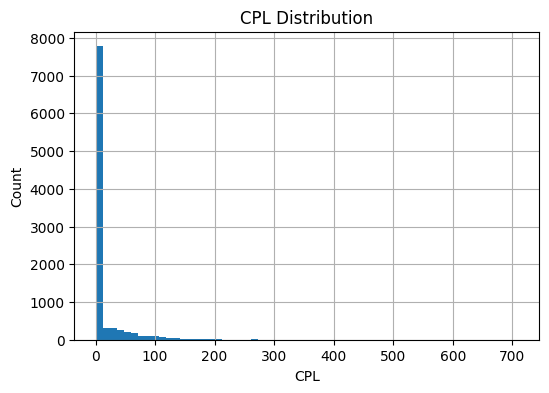

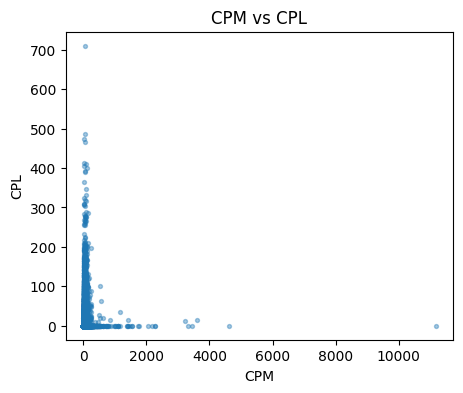

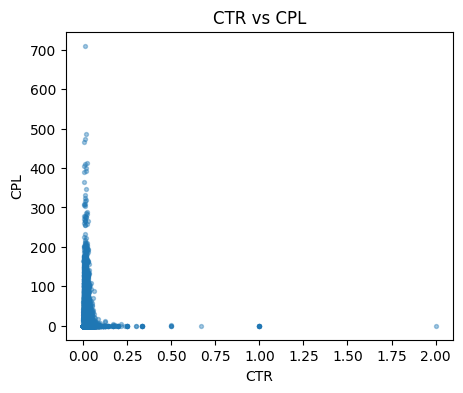

In [19]:
# CPL histogram
if eda_df["CPL"].notna().sum() > 5:
    plt.figure(figsize=(6,4))
    eda_df["CPL"].dropna().hist(bins=60)
    plt.title("CPL Distribution")
    plt.xlabel("CPL"); plt.ylabel("Count")
    plt.show()

# CPM vs CPL (cost pressure vs outcome)
plt.figure(figsize=(5,4))
plt.scatter(eda_df["CPM"], eda_df["CPL"], s=8, alpha=0.4)
plt.title("CPM vs CPL"); plt.xlabel("CPM"); plt.ylabel("CPL")
plt.show()

# CTR vs CPL (engagement vs outcome)
plt.figure(figsize=(5,4))
plt.scatter(eda_df["CTR"], eda_df["CPL"], s=8, alpha=0.4)
plt.title("CTR vs CPL"); plt.xlabel("CTR"); plt.ylabel("CPL")
plt.show()

In [20]:
# CPL segment tables (rank by low median & low std)

def segment_table(df, by, min_n=50):
    cols = by + ["CPL"]
    if not set(cols).issubset(df.columns):
        return None
    t = (df.dropna(subset=["CPL"])
           .groupby(by)["CPL"]
           .agg(count="count", mean="mean", median="median", std="std"))
    t = t.assign(cv = t["std"] / (t["mean"].replace(0, np.nan).abs()))
    t = (t.reset_index()
           .query("count >= @min_n")
           .sort_values(["median","std","count"], ascending=[True,True,False]))
    return t

segment_specs = [
    ["Platform"], ["Device platform"], ["Objective"],
    ["Platform","Device platform"]
]

for spec in segment_specs:
    t = segment_table(eda_df, spec, min_n=50)
    if t is not None and len(t):
        print(f"\nTop segments by {spec} (low median CPL, small dispersion):")
        print(t.head(10))



Top segments by ['Platform'] (low median CPL, small dispersion):
    Platform  count       mean  median        std        cv
2  instagram   4101  10.183155     0.0  31.240187  3.067830
1   facebook   5498  15.328131     0.0  41.031092  2.676849

Top segments by ['Device platform'] (low median CPL, small dispersion):
  Device platform  count       mean  median        std        cv
2      mobile_web    763   0.125225     0.0   1.240700  9.907750
0         desktop    659   0.582563     0.0   2.986082  5.125771
1      mobile_app   8195  15.321016     0.0  39.895482  2.603971

Top segments by ['Objective'] (low median CPL, small dispersion):
            Objective  count       mean  median       std        cv
2  OUTCOME_ENGAGEMENT    473   0.000000     0.0   0.00000       NaN
0         LINK_CLICKS     99   0.000000     0.0   0.00000       NaN
3       OUTCOME_LEADS   9040  13.941945     0.0  38.23712  2.742596

Top segments by ['Platform', 'Device platform'] (low median CPL, small dispersion

## EDA Summary (CPL Segments)

Dataset: 9,617 rows, CPL present on all rows but with heavy zero-inflation.

Most segments show median CPL = 0, driven by rows with 0 leads or non-lead objectives. Segments that appear “best” (e.g., mobile_web, desktop) are largely zero-only.

Actionable signal lives in mobile_app (majority of delivery), where mean CPL is non-zero but dispersion is high.

Recommendation for baselines/segments:
 - Recompute effective CPL = Amount spent / Leads; set NaN when Leads==0 (do not record 0) -> See below for amount of data left if feasible to utilise
 - Could utilise gates (e.g., Impressions ≥ 100 and Amount spent ≥ 5) to avoid no-delivery rows.
 - Rank segments by median effective CPL, with dispersion (IQR/std) and measurable coverage (share of rows with Leads>0).
 - Validate stability by month (same ranking holds across time).
 - Things you can utilise if needed: engineered features, leakage-safe feature lists, chronological split policy, and a ready preprocessor (see earlier cells).

In [21]:
df_train = eda_df.copy()

df_train["CPL_eff"] = np.where(
    (pd.to_numeric(df_train.get("Leads", 0), errors="coerce") > 0) &
    (pd.to_numeric(df_train.get("Amount spent", 0), errors="coerce") > 0),
    pd.to_numeric(df_train["Amount spent"], errors="coerce") /
    pd.to_numeric(df_train["Leads"], errors="coerce"),
    np.nan
)

def segment_table(df, by, min_n=50):
    cols = by + ["CPL_eff"]
    if not set(cols).issubset(df.columns):
        return None
    t = (df.dropna(subset=["CPL_eff"])
           .groupby(by)["CPL_eff"]
           .agg(count="count", mean="mean", median="median", std="std"))
    t = t.assign(cv = t["std"] / (t["mean"].replace(0, np.nan).abs()))
    t = (t.reset_index()
           .query("count >= @min_n")
           .sort_values(["median","std","count"], ascending=[True,True,False]))
    return t

for spec in segment_specs:
    t = segment_table(df_train, spec, min_n=50)
    if t is not None and len(t):
        print(f"\nTop segments by {spec} (low median CPL, small dispersion):")
        print(t.head(10))


Top segments by ['Platform'] (low median CPL, small dispersion):
    Platform  count       mean     median        std        cv
1  instagram    701  59.573634  44.560000  52.627946  0.883410
0   facebook   1294  65.126788  47.368333  62.543051  0.960328

Top segments by ['Device platform'] (low median CPL, small dispersion):
  Device platform  count       mean   median        std        cv
1      mobile_app   1942  64.652794  47.7625  59.398013  0.918723

Top segments by ['Objective'] (low median CPL, small dispersion):
       Objective  count      mean     median        std        cv
0  OUTCOME_LEADS   1995  63.17553  46.241664  59.294386  0.938566

Top segments by ['Platform', 'Device platform'] (low median CPL, small dispersion):
    Platform Device platform  count       mean  median        std        cv
3  instagram      mobile_app    701  59.573634   44.56  52.627946  0.883410
1   facebook      mobile_app   1241  67.521844   49.72  62.739853  0.929179


In [22]:
df_train.columns

Index(['Campaign ID', 'Ad set ID', 'Included custom audiences',
       'Excluded custom audiences', 'Custom Audience Defined',
       'Exclusion Defined', 'Ad ID', 'Campaign-Adset-Ad', 'Ads', 'Month',
       'Device platform', 'Platform', 'Currency', 'Amount spent', 'CPM',
       'Reach', 'Impressions', 'Clicks', 'Leads', 'CPL', 'Meta leads',
       'Objective', 'headline', 'Local Language', 'Event', 'Exclusivity',
       'Rental', 'Returns', 'Discounts', 'Frequency', 'Reporting starts',
       'Reporting ends', 'CTR', 'LeadRate', 'SpendPerImpr', 'ConvRate',
       'has_impr', 'has_clicks', 'has_leads', 'month_start', 'month_end',
       'year', 'month', 'quarter', 'month_period', 'headline_len',
       'headline_words', 'headline_has_num', 'hl_embed_0', 'hl_embed_1',
       'hl_embed_2', 'hl_embed_3', 'hl_embed_4', 'hl_embed_5', 'hl_embed_6',
       'hl_embed_7', 'hl_embed_8', 'hl_embed_9', 'hl_embed_10', 'hl_embed_11',
       'hl_embed_12', 'hl_embed_13', 'hl_embed_14', 'hl_embed_15'

In [23]:
Features_to_utilise = [
    "Platform","Device platform","Objective",
    "Included custom audiences","Excluded custom audiences",
    "Local Language","Event","Exclusivity","Rental","Returns","Discounts",
    "Frequency","headline_len","headline_words","headline_has_num",
] \
+ [c for c in ["month","year"] if c in fe_platform_df.columns] # for seasonality
# + [col for col in fe_platform_df.columns if col.startswith("hl_embed_")]

# Can consider CTR, SpendPerImpr, CPM
Features_to_utilise
# Obj -> Minimize expected CPL

['Platform',
 'Device platform',
 'Objective',
 'Included custom audiences',
 'Excluded custom audiences',
 'Local Language',
 'Event',
 'Exclusivity',
 'Rental',
 'Returns',
 'Discounts',
 'Frequency',
 'headline_len',
 'headline_words',
 'headline_has_num',
 'month',
 'year']

In [24]:
for c in [
    "Platform","Device platform","Objective",
    "Local Language","Event","Exclusivity","Rental","Returns","Discounts",
    "Frequency","headline_len","headline_words","headline_has_num",
] :
  print("/////////////////")
  print(f'NaN Count: {df_train[c].isna().sum()}')
  display(df_train[c].value_counts())


/////////////////
NaN Count: 0


Platform
facebook            5498
instagram           4101
audience_network      14
messenger              4
Name: count, dtype: int64

/////////////////
NaN Count: 0


Device platform
mobile_app    8195
mobile_web     763
desktop        659
Name: count, dtype: int64

/////////////////
NaN Count: 0


Objective
OUTCOME_LEADS         9040
OUTCOME_ENGAGEMENT     473
LINK_CLICKS             99
OUTCOME_AWARENESS        5
Name: count, dtype: int64

/////////////////
NaN Count: 0


Local Language
nan    8157
0.0     792
1.0     668
Name: count, dtype: int64

/////////////////
NaN Count: 0


Event
1.0    6845
nan    1980
0.0     792
Name: count, dtype: int64

/////////////////
NaN Count: 5951


Exclusivity
1.0    2874
0.0     792
Name: count, dtype: int64

/////////////////
NaN Count: 8383


Rental
0.0    792
1.0    442
Name: count, dtype: int64

/////////////////
NaN Count: 8319


Returns
0.0    792
1.0    506
Name: count, dtype: int64

/////////////////
NaN Count: 8735


Discounts
0.0    792
1.0     90
Name: count, dtype: int64

/////////////////
NaN Count: 0


Frequency
1.000000    1029
1.250000      90
1.333333      88
1.500000      74
1.200000      73
            ... 
1.382716       1
1.272989       1
1.377752       1
1.134529       1
1.330645       1
Name: count, Length: 5872, dtype: int64

/////////////////
NaN Count: 0


headline_len
44     1117
3       792
43      437
51      390
52      346
       ... 
99       10
96        8
59        7
92        2
104       2
Name: count, Length: 76, dtype: int64

/////////////////
NaN Count: 0


headline_words
8     1520
6     1376
1     1129
11     995
7      994
9      954
10     586
12     531
5      381
13     334
15     223
14     200
4      134
17     105
3       67
16      44
2       34
19       8
18       2
Name: count, dtype: Int64

/////////////////
NaN Count: 0


headline_has_num
1    5089
0    4528
Name: count, dtype: int64

## Split into Train-Test

In [25]:
df_train, df_test = train_test_split(fe_platform_df, test_size=0.2, random_state=42, shuffle=True)

## Benchmark (Non-Graph Based K-means)

### Feel free to comment if below approach is ok or not
### Benchmark Approach:
1. Using the train dataset with CPL, iteratively run K-means from 2 clusters to 10 clusters, and compute their silhouette score.
2. Using the elbow method on the silhouette scores, and visual inspection on the cluster statistics (How nice the CPL is split), select a optimal cluster count.
3. Use a Random Forest classifier on the train dataset (Now without CPL), to predict the cluster it belongs to which is computed in the previous step.
4. Run test set through decision tree to predict the cluster it belongs to. Prediction is correct if the true CPL falls within the CPL range in the cluster. 

### Evaluation Metrics:
#### For clustering:
- Silhouette Score (Higher = Better): Measures how similar a data point is to its own cluster (cohesion) compared to other clusters (separation). Takes into account all the columns involved.
- Weighted Avg Intra Cluster CPL Variance (Lower = Better): Weighted sum of variances of CPL of all clusters.

#### For Prediction of CPL:
- Accuracy/F1 (Higher=Better): Measures if a data point is correctly assigned to the correct cluster. 
    **Note that the correct cluster for an entry in the test set is computed by computing the closest cluster using the Train Set KMeans Model, since we do not have ground truth cluster.**


Question: Why not just directly predict CPL (e.g. linear regression)? Why go through the trouble to cluster first then predict the cluster which causes a loss in information?
Justification(?): By predicting cluster for a data entry, we directly identify if its gonna be low CPL or not.

In [26]:
bm_kmeans_features = [
    "Platform","Device platform","Objective",
    # "Included custom audiences","Excluded custom audiences", <= Omitted cuz they're strings
    # "Local Language", "Exclusivity","Rental","Returns","Discounts", # <= Omitted cuz too much nan
    "Event", "Frequency","headline_len","headline_words","headline_has_num", 'CPL'
] \
+ [c for c in ["month","year"] if c in df_train.columns] # for seasonality
# + [c for c in df_train.columns if c.startswith('hl_embed_')] <= Tried this but no improvement

train_bm_kmeans_df = df_train[bm_kmeans_features]
test_bm_kmeans_df = df_test[bm_kmeans_features]
train_bm_kmeans_df.head()

,Platform,Device platform,Objective,Event,Frequency,headline_len,headline_words,headline_has_num,CPL,month,year
3710,facebook,mobile_app,OUTCOME_LEADS,1.0,2.027027,54,9,1,0.000,5,2024
675,facebook,mobile_app,OUTCOME_LEADS,1.0,1.429416,27,1,1,128.025,1,2024
5279,facebook,mobile_app,OUTCOME_LEADS,1.0,1.360870,44,10,1,0.000,10,2024
6794,facebook,desktop,OUTCOME_LEADS,1.0,1.333333,44,6,0,0.000,3,2025
7650,instagram,mobile_app,OUTCOME_LEADS,1.0,1.054054,43,8,0,0.000,3,2025


In [27]:
from sklearn import pipeline
from sklearn.base import clone
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, scale
from sklearn.compose import make_column_transformer
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.impute import SimpleImputer

def wavg_intra_cluster_cpl_var_score(cpl_col, cluster):
    '''
    Computes the weight average intra cluster CPL variance score,
    or how tight out the CPL variance is according to the formula: sum_k[ (N_i / N_total) * var(i) ]

    Assuming k clusters,
    N_i: number of data points in cluster i
    N_total: number of data points in total
    var(i): Variance of cluster i
    '''    
    df = pd.DataFrame({'CPL': cpl_col, 'cluster': cluster})
    total_counts = df.shape[0]

    grouped_clusters = df.groupby('cluster')['CPL']
    cluster_variances = grouped_clusters.var()
    cluster_counts = grouped_clusters.count()

    metric = ((cluster_counts / total_counts) * cluster_variances).sum()
    return metric


def compute_cluster_CPL_stats(cpl_col, cluster):
  '''
  Computes statistics of CPL in a cluster (Mean, median, std)

  cpl_col: A series constaining the CPL.
  cluster: A numpy list indiciating which cluster a element in the series belongs.

  Return a tuple containing a dataframe containing summary statistics of each cluster, and also the weighted average CPL variance score.
  '''
  df = pd.DataFrame({'CPL': cpl_col, 'cluster': cluster})
  cluster_stats = (df.groupby('cluster')['CPL'].describe().sort_values('mean'))
  wvag_cpl_var = wavg_intra_cluster_cpl_var_score(cpl_col, cluster)

  return cluster_stats, wvag_cpl_var

  

bm_kmeans_preprocessor = lambda cpl_weight: make_column_transformer(
    (SimpleImputer(missing_values=np.nan, strategy='median'), ['Event']),
    (OneHotEncoder(handle_unknown='ignore'), ['Platform', 'Device platform', 'Objective']),
    (StandardScaler(), ['Frequency', 'headline_len', 'headline_words', 'headline_has_num', 'CPL', 'month', 'year']),
    (FunctionTransformer(lambda x: x * cpl_weight), ['CPL']), # Multiply weight after standardizing
    remainder='passthrough',
)

bm_kmeans_pipe = lambda n_clusters, cpl_weight: make_pipeline(
    bm_kmeans_preprocessor(cpl_weight),
    MiniBatchKMeans(n_clusters=n_clusters, random_state=0, n_init="auto")
)

For n_cluster=2, silhouette_score=0.8549, wavg_CPL_score=468.7195, 
cluster_cpl_stats:
          count    mean   std    min    25%   50%     75%     max
cluster                                                          
1        7022.0    3.79  11.0   0.00   0.00   0.0    0.00   54.93
0         671.0  112.14  64.1  54.95  68.84  93.4  131.57  486.50

For n_cluster=3, silhouette_score=0.8370, wavg_CPL_score=227.6181, 
cluster_cpl_stats:
          count    mean    std     min     25%     50%     75%     max
cluster                                                               
1        6622.0    1.45   5.43    0.00    0.00    0.00    0.00   31.18
0         867.0   62.98  23.69   31.23   42.94   58.14   79.93  120.26
2         204.0  184.47  72.41  121.28  138.22  161.15  195.15  486.50

For n_cluster=4, silhouette_score=0.7223, wavg_CPL_score=203.8060, 
cluster_cpl_stats:
          count      mean    std     min     25%     50%     75%     max
cluster                                      

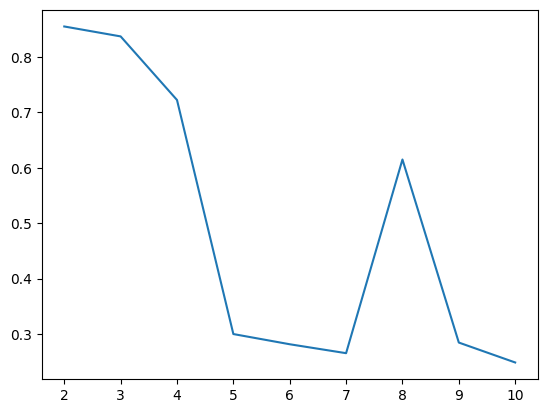

In [28]:
def run_bm_kmeans(df, n_cluster, cpl_weight=1):
    '''
    Runs 1 kmeans iteration, with all the preprocessing and stuff, to create n_clusters.
    This method runs the kmeans pipeline.

    cpl_weight: How much to scale it, aka give it more importance.
    '''
    pipe = bm_kmeans_pipe(n_cluster, cpl_weight)

    bm_kmeans_model = clone(pipe).fit(df)
    bm_kmeans_pred = bm_kmeans_model.predict(df)
    bm_kmeans_ss = silhouette_score(clone(bm_kmeans_preprocessor(cpl_weight)).fit_transform(df), bm_kmeans_pred)

    return bm_kmeans_model, bm_kmeans_pred, bm_kmeans_ss

def iterate_bm_kmeans(df_train, cpl_weight=1, min_clusters=2, max_clusters=10):
  '''
  Iterates thru some kmeans from min_clusters and max_clusters, and print out their silhouette scores and cluster statistics.
  '''
  df_train = df_train.copy()

  silhouette_scores = []
  for n_cluster in range(min_clusters, max_clusters+1):
    _, bm_kmeans_pred, bm_kmeans_ss = run_bm_kmeans(df_train, n_cluster, cpl_weight)
    cluster_cpl_stats, wvag_cpl_var = compute_cluster_CPL_stats(df_train['CPL'], bm_kmeans_pred)

    with pd.option_context('display.precision', 2):
      print(f'For n_cluster={n_cluster}, silhouette_score={bm_kmeans_ss:.4f}, wavg_CPL_score={wvag_cpl_var:.4f}, \ncluster_cpl_stats:\n{cluster_cpl_stats}\n')

    silhouette_scores.append(bm_kmeans_ss)
  plt.plot(range(min_clusters, max_clusters+1), silhouette_scores)
  plt.show()

bm_kmeans_cpl_weight = 1
iterate_bm_kmeans(train_bm_kmeans_df, cpl_weight=bm_kmeans_cpl_weight) # Seems like cpl_weight = 1 works well already

In [29]:
train_bm_kmeans_df.head()

,Platform,Device platform,Objective,Event,Frequency,headline_len,headline_words,headline_has_num,CPL,month,year
3710,facebook,mobile_app,OUTCOME_LEADS,1.0,2.027027,54,9,1,0.000,5,2024
675,facebook,mobile_app,OUTCOME_LEADS,1.0,1.429416,27,1,1,128.025,1,2024
5279,facebook,mobile_app,OUTCOME_LEADS,1.0,1.360870,44,10,1,0.000,10,2024
6794,facebook,desktop,OUTCOME_LEADS,1.0,1.333333,44,6,0,0.000,3,2025
7650,instagram,mobile_app,OUTCOME_LEADS,1.0,1.054054,43,8,0,0.000,3,2025


In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import accuracy_score, f1_score, adjusted_rand_score

bm_rand_forest_preprocessor = make_column_transformer(
    (OrdinalEncoder(), ['Platform', 'Device platform', 'Objective']),
    remainder='passthrough',
)

bm_rand_forest_pipe = make_pipeline(
    bm_rand_forest_preprocessor,
    RandomForestClassifier(random_state=seed)
)

# We pick n_clusters = 7 using elbow method.
chosen_n_clusters = 7
bm_kmeans_model_train, bm_kmeans_clusters_train, bm_kmeans_ss_train = run_bm_kmeans(train_bm_kmeans_df, chosen_n_clusters, cpl_weight=bm_kmeans_cpl_weight)
cluster_cpl_stats, wvag_cpl_var = compute_cluster_CPL_stats(train_bm_kmeans_df['CPL'], bm_kmeans_clusters_train)
with pd.option_context('display.precision', 2):
      print(f'For n_cluster={chosen_n_clusters}, silhouette_score={bm_kmeans_ss_train:.4f}, wavg_CPL_score={wvag_cpl_var:.4f}, \ncluster_cpl_stats:\n{cluster_cpl_stats}\n')

bm_kmeans_clusters_test = bm_kmeans_model_train.predict(test_bm_kmeans_df)

bm_rand_forest = clone(bm_rand_forest_pipe).fit(train_bm_kmeans_df, bm_kmeans_clusters_train)
bm_rand_forest_pred_train = bm_rand_forest.predict(train_bm_kmeans_df)
bm_rand_forest_pred_test = bm_rand_forest.predict(test_bm_kmeans_df)

wavg_intra_cluster_cpl_var_score(train_bm_kmeans_df['CPL'], bm_kmeans_clusters_train)

print(
    f'Train Value Counts for Each Cluster: {np.unique_counts(bm_kmeans_clusters_train).counts}',
    f'\n'
    f'Test Value Counts for Each Cluster: {np.unique_counts(bm_kmeans_clusters_test).counts}'
)

print(
    f'TRAIN Accuracy: {accuracy_score(bm_kmeans_clusters_train, bm_rand_forest_pred_train):.4f}',
    f'TEST Accuracy: {accuracy_score(bm_kmeans_clusters_test, bm_rand_forest_pred_test):.4f}',
    f'\n'
    f'TRAIN F1: {f1_score(bm_kmeans_clusters_train, bm_rand_forest_pred_train, average="weighted"):.4f}',
    f'TEST F1: {f1_score(bm_kmeans_clusters_test, bm_rand_forest_pred_test, average="weighted"):.4f}',
)


For n_cluster=7, silhouette_score=0.2653, wavg_CPL_score=113.7696, 
cluster_cpl_stats:
          count    mean    std     min     25%     50%     75%     max
cluster                                                               
6        2532.0    0.02   0.43    0.00    0.00    0.00    0.00   10.73
3         885.0    0.03   0.53    0.00    0.00    0.00    0.00   12.51
1        2851.0    0.50   2.25    0.00    0.00    0.00    0.00   14.60
5         608.0   29.23   8.70   14.65   21.88   28.70   36.54   44.86
0         435.0   62.08  11.12   45.03   52.34   61.02   70.47   85.72
4         282.0  115.06  21.66   85.82   97.52  109.63  130.67  161.61
2         100.0  231.12  79.24  163.26  175.76  195.63  272.42  486.50

Train Value Counts for Each Cluster: [ 435 2851  100  885  282  608 2532] 
Test Value Counts for Each Cluster: [109 684  18 258  73 151 631]
TRAIN Accuracy: 1.0000 TEST Accuracy: 0.9901 
TRAIN F1: 1.0000 TEST F1: 0.9901


### time for nn approaches

In [101]:
fe_platform_df.columns

Index(['Campaign ID', 'Ad set ID', 'Included custom audiences',
       'Excluded custom audiences', 'Custom Audience Defined',
       'Exclusion Defined', 'Ad ID', 'Campaign-Adset-Ad', 'Ads', 'Month',
       'Device platform', 'Platform', 'Currency', 'Amount spent', 'CPM',
       'Reach', 'Impressions', 'Clicks', 'Leads', 'CPL', 'Meta leads',
       'Objective', 'headline', 'Local Language', 'Event', 'Exclusivity',
       'Rental', 'Returns', 'Discounts', 'Frequency', 'Reporting starts',
       'Reporting ends', 'CTR', 'LeadRate', 'SpendPerImpr', 'ConvRate',
       'has_impr', 'has_clicks', 'has_leads', 'month_start', 'month_end',
       'year', 'month', 'quarter', 'month_period', 'headline_len',
       'headline_words', 'headline_has_num', 'hl_embed_0', 'hl_embed_1',
       'hl_embed_2', 'hl_embed_3', 'hl_embed_4', 'hl_embed_5', 'hl_embed_6',
       'hl_embed_7', 'hl_embed_8', 'hl_embed_9', 'hl_embed_10', 'hl_embed_11',
       'hl_embed_12', 'hl_embed_13', 'hl_embed_14', 'hl_embed_15'

In [173]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score
from scipy.sparse.linalg import eigsh
from scipy.sparse import diags, eye, csr_matrix
from sklearn.neighbors import kneighbors_graph
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
import torch.nn.functional as F

def set_all_seeds(seed):
    """Sets seed for NumPy, Python, and PyTorch (CPU & GPU)."""
    np.random.seed(seed) 
    import random 
    random.seed(seed)
    
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True 
        torch.backends.cudnn.benchmark = False

seed = 777
set_all_seeds(seed)

SCALED_NUMERIC_COLS = [
    'Frequency', 'headline_len', 'headline_words', 'headline_has_num', 
    'month', 'year', 'CTR', 'SpendPerImpr', 'LeadRate'
]

SCALED_NUMERIC_COLS.extend([col for col in fe_platform_df.columns if col.startswith('hl_embed_')])
OHE_CATEGORICAL_COLS = ['Platform', 'Device platform', 'Objective'] 

K_CLUSTERS = 7 

In [174]:
def calculate_effective_cpl(df):
    """Calculates CPL_eff and ensures all relevant columns are numeric/string types."""
    df = df.copy()
    amount_spent = pd.to_numeric(df.get("Amount spent", 0), errors="coerce")
    leads = pd.to_numeric(df.get("Leads", 0), errors="coerce")
    df["CPL_eff"] = np.where( (leads > 0) & (amount_spent > 0), amount_spent / leads, np.nan )
    
    for col in SCALED_NUMERIC_COLS:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce').astype(np.float64)
    for col in OHE_CATEGORICAL_COLS:
        if col in df.columns:
            df[col] = df[col].astype(str)
    return df

def robust_impute_and_force_float(X_raw, is_train=True, imputer_fitted=None):
    """Forces conversion to float32 and imputes any residual NaNs in the NumPy array."""
    if hasattr(X_raw, 'toarray'):
        X = X_raw.toarray()
    else:
        X = X_raw

    X = X.astype(np.float32)

    imputer = SimpleImputer(strategy='median')
    if is_train:
        X_imputed = imputer.fit_transform(X)
        return X_imputed, imputer
    else:
        if imputer_fitted is None:
            raise ValueError("Test set requires a fitted imputer from the training data.")
        return imputer_fitted.transform(X), imputer_fitted


df_train_raw, df_test_raw = train_test_split(fe_platform_df, test_size=0.2, random_state=42, shuffle=True)
df_train = calculate_effective_cpl(df_train_raw).dropna(subset=['CPL_eff'])
df_test = calculate_effective_cpl(df_test_raw).dropna(subset=['CPL_eff'])

transformer_definitions = [
    ("num_pipe", Pipeline([("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]), SCALED_NUMERIC_COLS),
    ("cat_pipe", OneHotEncoder(handle_unknown="ignore"), OHE_CATEGORICAL_COLS)
]
preprocessor = ColumnTransformer(transformer_definitions, remainder="drop")

X_train_raw = preprocessor.fit_transform(df_train)
X_test_raw = preprocessor.transform(df_test)

X_train, final_imputer = robust_impute_and_force_float(X_train_raw, is_train=True)
X_test, _ = robust_impute_and_force_float(X_test_raw, is_train=False, imputer_fitted=final_imputer)

CPL_THRESHOLD = df_train['CPL_eff'].median() 
df_train['is_low_cpl'] = (df_train['CPL_eff'] <= CPL_THRESHOLD).astype(int)
df_test['is_low_cpl'] = (df_test['CPL_eff'] <= CPL_THRESHOLD).astype(int)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_binary = torch.tensor(df_train['is_low_cpl'].values, dtype=torch.float32)
y_test_binary = torch.tensor(df_test['is_low_cpl'].values, dtype=torch.float32)

INPUT_DIM = X_train_tensor.shape[1]
print(f"Data Preparation Complete. Final Input Dimension: {INPUT_DIM}")

Data Preparation Complete. Final Input Dimension: 47


In [175]:
# --- GCN/DNN Model Definitions ---

class DNNClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim_1=128, hidden_dim_2=64, num_classes=1):
        super(DNNClassifier, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim_1),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim_1),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim_1, hidden_dim_2),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim_2),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim_2, num_classes)
        )
    def forward(self, x):
        return self.network(x).squeeze(1)

class GCNLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_features, out_features, bias=True)
        nn.init.xavier_uniform_(self.linear.weight)
    def forward(self, H, A_tilde):
        H_lin = self.linear(H)
        H_out = torch.matmul(A_tilde, H_lin)
        return H_out

class GCNClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_classes=1, num_layers=2):
        super(GCNClassifier, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(GCNLayer(input_dim, hidden_dim))
        for _ in range(num_layers - 1):
            self.layers.append(GCNLayer(hidden_dim, hidden_dim))
        self.layers.append(GCNLayer(hidden_dim, num_classes))
        self.relu = nn.ReLU()
    def forward(self, X_features, A_tilde):
        H = X_features
        for i, layer in enumerate(self.layers):
            H = layer(H, A_tilde)
            if i < len(self.layers) - 1:
                H = self.relu(H)
        return H.squeeze(1) if self.layers[-1].linear.out_features == 1 else H

def build_knn_adjacency(X_features, n_neighbors=15):
    A = kneighbors_graph(X_features, n_neighbors=n_neighbors, mode='connectivity', include_self=False, metric='euclidean')
    return A.maximum(A.T).tocsr()

def get_gcn_prop_matrix(A_sparse):
    A_hat = A_sparse + eye(A_sparse.shape[0])
    D_hat = diags(A_hat.sum(axis=1).flatten().tolist()[0])
    D_hat_inv_sqrt = diags(1.0 / np.sqrt(D_hat.data[0]))
    A_tilde_sparse = D_hat_inv_sqrt @ A_hat @ D_hat_inv_sqrt
    return torch.tensor(A_tilde_sparse.toarray(), dtype=torch.float32)

def compute_adjacency_spectral_embedding(A_sparse, n_clusters):
    """
    Computes the top K non-trivial eigenvectors of the Symmetric Normalized Adjacency Matrix (A_sym).
    This avoids the singularity issue of the Laplacian when components are disconnected.
    """
    N = A_sparse.shape[0]
    
    # Compute Degree Matrix D and D^-1/2
    D = diags(A_sparse.sum(axis=1).flatten().tolist()[0])
    D_inv_sqrt = diags(1.0 / np.sqrt(D.data[0]))
    
    # Compute Symmetric Normalized Adjacency Matrix: A_sym = D^-1/2 * A * D^-1/2
    A_sym = D_inv_sqrt @ A_sparse @ D_inv_sqrt
    A_sym = (A_sym + A_sym.T) / 2 # Ensure symmetry
    
    # Compute K eigenvectors corresponding to the LARGEST (LA) eigenvalues.
    # The largest eigenvectors of A_sym correspond to the smallest of L_sym.
    # We compute n_clusters eigenvectors (no need to discard u_0 here).
    
    # K_CLUSTERS = 7. We request K=7.
    eigenvalues, Y = eigsh(A_sym, k=n_clusters, which='LA', sigma=None)
    
    # Y is the spectral embedding matrix of size (N x n_clusters)
    return Y

def wavg_intra_cluster_cpl_var_score(cpl_col, cluster):
    df = pd.DataFrame({'CPL_eff': cpl_col, 'cluster': cluster})
    total_counts = df.shape[0]
    grouped_clusters = df.groupby('cluster')['CPL_eff']
    cluster_variances = grouped_clusters.var().fillna(0)
    cluster_counts = grouped_clusters.count()
    metric = ((cluster_counts / total_counts) * cluster_variances).sum()
    return metric

In [176]:
def train_classifier_model(model, X, y, A_tilde=None, epochs=200, lr=1e-3, graph_model=False):
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr if not graph_model else 1e-2)
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        logits = model(X, A_tilde) if graph_model else model(X)
        loss = loss_fn(logits, y)
        loss.backward()
        optimizer.step()
    return model

def evaluate_classifier_model(model, X, y, A_tilde=None, graph_model=False):
    model.eval()
    with torch.no_grad():
        logits = model(X, A_tilde) if graph_model else model(X)
        predictions = (torch.sigmoid(logits) > 0.5).int()
        accuracy = (predictions == y.int()).sum().item() / len(y)
        f1 = f1_score(y.numpy(), predictions.numpy(), average='binary')
    return accuracy, f1

A_train_knn = build_knn_adjacency(X_train)
A_tilde_train = get_gcn_prop_matrix(A_train_knn)
A_tilde_test = get_gcn_prop_matrix(build_knn_adjacency(X_test))


## BASELINE 1: DNN CLASSIFIER (Classification Only)

print("\n--- 1. DNN CLASSIFIER (Low-CPL Label) ---")
dnn_model = DNNClassifier(input_dim=INPUT_DIM, num_classes=1)
dnn_model = train_classifier_model(dnn_model, X_train_tensor, y_train_binary, epochs=200)

dnn_acc_train, dnn_f1_train = evaluate_classifier_model(dnn_model, X_train_tensor, y_train_binary)
dnn_acc_test, dnn_f1_test = evaluate_classifier_model(dnn_model, X_test_tensor, y_test_binary)

print(f"DNN TRAIN Accuracy: {dnn_acc_train:.4f} | F1: {dnn_f1_train:.4f}")
print(f"DNN TEST Accuracy: {dnn_acc_test:.4f} | F1: {dnn_f1_test:.4f}")

## BASELINE 2: GCN CLASSIFIER (Classification with Graph Structure)

print("\n--- 2. GCN CLASSIFIER (Low-CPL Label) ---")
gcn_model = GCNClassifier(input_dim=INPUT_DIM, num_classes=1)
gcn_model = train_classifier_model(gcn_model, X_train_tensor, y_train_binary, A_tilde=A_tilde_train, epochs=200, graph_model=True)

gcn_acc_train, gcn_f1_train = evaluate_classifier_model(gcn_model, X_train_tensor, y_train_binary, A_tilde=A_tilde_train, graph_model=True)
gcn_acc_test, gcn_f1_test = evaluate_classifier_model(gcn_model, X_test_tensor, y_test_binary, A_tilde=A_tilde_test, graph_model=True)

print(f"GCN TRAIN Accuracy: {gcn_acc_train:.4f} | F1: {gcn_f1_train:.4f}")
print(f"GCN TEST Accuracy: {gcn_acc_test:.4f} | F1: {gcn_f1_test:.4f}")

## BASELINE 3: SPECTRAL CLUSTERING (Homogeneity Comparison)
# check if groupings identified by the graph structure are meaningful with respect to CPL

print("\n--- 3. SPECTRAL CLUSTERING (Homogeneity - A_sym Stable) ---")

# Compute Spectral Embedding (using the stable Adjacency Matrix method)
# A_train_knn is the raw kNN adjacency matrix computed previously.
Y_spectral_train = compute_adjacency_spectral_embedding(A_train_knn, K_CLUSTERS)

# Run K-Means on Spectral Embedding
kmeans_spectral = KMeans(n_clusters=K_CLUSTERS, random_state=42, n_init='auto').fit(Y_spectral_train)
spectral_labels_train = kmeans_spectral.labels_

# Compute Homogeneity Metric
CPL_train_eff_np = df_train['CPL_eff'].values
spectral_wavg_var = wavg_intra_cluster_cpl_var_score(CPL_train_eff_np, spectral_labels_train)

# Compute Silhouette Score
spectral_ss = silhouette_score(X_train, spectral_labels_train)

print(f"K={K_CLUSTERS} Clusters:")
print(f"Spectral Silhouette Score (on feature space): {spectral_ss:.4f}")
print(f"Spectral WAvg CPL Variance (Homogeneity): {spectral_wavg_var:.4f}")


--- 1. DNN CLASSIFIER (Low-CPL Label) ---
DNN TRAIN Accuracy: 0.9071 | F1: 0.9107
DNN TEST Accuracy: 0.7512 | F1: 0.7706

--- 2. GCN CLASSIFIER (Low-CPL Label) ---
GCN TRAIN Accuracy: 0.7414 | F1: 0.7190
GCN TEST Accuracy: 0.5522 | F1: 0.6341

--- 3. SPECTRAL CLUSTERING (Homogeneity - A_sym Stable) ---
K=7 Clusters:
Spectral Silhouette Score (on feature space): -0.0241
Spectral WAvg CPL Variance (Homogeneity): 3490.2786


bad results above, local message passing destroys the signal, over-smoothing or destructive interference, resulting in near-random test accuracy. 

structural similarity defined by the kNN graph is introducing noise, not signal. score is bad (silhouette is negative, spectral wavg CPL variance is 3490), meaning the structural similarity found by the graph does not correlate well with cost homogeneity when we use spectral embedding + kmeans, and ad features and structure are diffuse and poorly defined (not naturally separable)

lets try anisotropic gcn

test if connecting ads by common identity (Platform, Objective) provides a better structural signal than feature distance ($\mathbf{A}_{\text{kNN}}$) for the anisotropic GCN.

In [177]:
from scipy.sparse import csr_matrix, diags, eye
import numpy as np

def get_shared_metadata_adjacency(df, features):
    """
    Creates an adjacency matrix A where A[i, j] = 1 if ad i and ad j share 
    the same value in ANY of the specified categorical features (Platform/Objective).
    
    Args:
        df (pd.DataFrame): DataFrame containing the categorical features.
        features (list): List of categorical column names to compare.
        
    Returns:
        A_shared (csr_matrix): Symmetric binary adjacency matrix.
    """
    N = df.shape[0]
    A_shared = csr_matrix((N, N), dtype=np.int8)

    for feature in features:

        df['temp_id'] = df[feature].astype('category').cat.codes
        
        for group_id, indices in df.groupby('temp_id').groups.items():
            indices_list = indices.to_list()
            
            if len(indices_list) > 1:
                # Create a dense subgraph matrix for this group
                subgraph = np.ones((len(indices_list), len(indices_list)), dtype=np.int8)
                np.fill_diagonal(subgraph, 0) # No self-loops
                
                # Convert group indices to their positions in the full adjacency matrix
                rows, cols = np.meshgrid(indices_list, indices_list)
                
                # Add the connectivity to the sparse matrix
                A_shared[rows.flatten(), cols.flatten()] = 1
        
        df = df.drop(columns='temp_id') # Clean up temp column

    return A_shared.tocsr().minimum(1)

# --- Define Features for Shared Graph ---
SHARED_GRAPH_FEATURES = ['Platform', 'Objective'] 

A_shared_train = get_shared_metadata_adjacency(df_train.reset_index(), SHARED_GRAPH_FEATURES)
A_shared_test = get_shared_metadata_adjacency(df_test.reset_index(), SHARED_GRAPH_FEATURES)

A_tilde_shared_train = get_gcn_prop_matrix(A_shared_train)
A_tilde_shared_test = get_gcn_prop_matrix(A_shared_test)

c:\Users\wl\Desktop\University\MComp (AI)\Graph Machine Learning_CS5284\.venv\Lib\site-packages\scipy\sparse\_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)
c:\Users\wl\Desktop\University\MComp (AI)\Graph Machine Learning_CS5284\.venv\Lib\site-packages\scipy\sparse\_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)
c:\Users\wl\Desktop\University\MComp (AI)\Graph Machine Learning_CS5284\.venv\Lib\site-packages\scipy\sparse\_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)
c:\Users\wl\Desktop\University\MComp (AI)\Graph Machine Learning_CS5284\.venv\Lib\site-packages\scipy\sparse\_index.py:210: SparseEfficiencyWarning: Changing the sparsity s

In [178]:
class GATLayer(nn.Module):
    """Simplified Anisotropic GAT-style Layer."""
    def __init__(self, in_features, out_features, n_heads=4):
        super(GATLayer, self).__init__()
        self.n_heads = n_heads
        self.out_features = out_features
        self.head_dim = out_features // n_heads
        
        # Linear projection (W * H) for each head
        self.W = nn.Linear(in_features, out_features)
        
        # Attention mechanism (a * [Wh_i || Wh_j])
        self.a = nn.Parameter(torch.empty(size=(2 * self.head_dim, 1)))
        nn.init.xavier_uniform_(self.a.data, gain=1.414)
        
        self.leakyrelu = nn.LeakyReLU(0.2)
        self.dropout = nn.Dropout(0.6)

    def forward(self, H, A_adj):
        N = H.size(0)
        
        Wh = self.W(H).view(N, self.n_heads, self.head_dim)

        H_aggregated = torch.matmul(A_adj, Wh.view(N, self.out_features))
        
        return F.elu(H_aggregated)

In [179]:
class AnisotropicGCNClassifier(nn.Module):
    """GCN using GAT-style layers for anisotropic propagation."""
    def __init__(self, input_dim, hidden_dim=64, num_classes=1, num_layers=2):
        super(AnisotropicGCNClassifier, self).__init__()
        
        self.layers = nn.ModuleList()
        # Attention layer
        self.layers.append(GATLayer(input_dim, hidden_dim, n_heads=4))
        
        # Hidden layers (using standard GCN style propagation as a fallback)
        for _ in range(num_layers - 1):
            self.layers.append(GCNLayer(hidden_dim, hidden_dim))
            
        self.layers.append(GCNLayer(hidden_dim, num_classes))
        self.relu = nn.ReLU()
        
    def forward(self, X_features, A_tilde):
        H = X_features
        # first layer is anisotropic GAT-style
        H = self.layers[0](H, A_tilde)
        
        # Remaining layers are simpler GCN propagation
        for i, layer in enumerate(self.layers[1:]):
            H = layer(H, A_tilde)
            if i < len(self.layers) - 2:
                H = self.relu(H)
        
        return H.squeeze(1)

In [180]:
print("\n--- 4. ANISOTROPIC GCN (Shared Metadata Graph) ---")

gcn_model_aniso = AnisotropicGCNClassifier(input_dim=INPUT_DIM, num_classes=OUTPUT_CLASSES)
gcn_model_aniso = train_classifier_model(gcn_model_aniso, X_train_tensor, y_train_binary, 
                                           A_tilde=A_tilde_shared_train, epochs=200, 
                                           lr=1e-3, graph_model=True)

gcn_acc_train_aniso, gcn_f1_train_aniso = evaluate_classifier_model(gcn_model_aniso, X_train_tensor, y_train_binary, A_tilde=A_tilde_shared_train, graph_model=True)
gcn_acc_test_aniso, gcn_f1_test_aniso = evaluate_classifier_model(gcn_model_aniso, X_test_tensor, y_test_binary, A_tilde=A_tilde_shared_test, graph_model=True)

print(f"ANISO TRAIN Accuracy: {gcn_acc_train_aniso:.4f} | F1: {gcn_f1_train_aniso:.4f}")
print(f"ANISO TEST Accuracy: {gcn_acc_test_aniso:.4f} | F1: {gcn_f1_test_aniso:.4f}")


--- 4. ANISOTROPIC GCN (Shared Metadata Graph) ---
ANISO TRAIN Accuracy: 0.5003 | F1: 0.6669
ANISO TEST Accuracy: 0.5199 | F1: 0.6841


even worse result. accuracy of the Anisotropic GCN is essentially random guessing
even though the GAT-style layer was implemented to be anisotropic (able to selectively weight messages), the fundamental problem remains,
the graph nodes connected by shared categories form large, homogenous, noisy clusters. the message passing process forces the model to average
features across all nodes sharing 'facebook' or 'OUTCOME_LEADS', which destroys the unique, high-fidelity feature combinations that the DNN used

since theres conflict between the strength of the node features and the noise in the graph structure, lets try hybrid (gatedgcn + dnn) to isolate the core problem, testing whether decoupling the features from the message passing could improve the approach

Feature Transformation (DNN Layer): An initial linear layer processes the raw input features (like the first layer of a DNN).

GCN/GAT Block: A GNN block then takes the output of the DNN layer and performs message passing using the structural matrix ($A_{\text{Shared}}$).

Final MLP: The final classification head.

In [181]:
class GatedGCNLayer(nn.Module):
    """GatedGCN Layer with Node and Edge Updates (Residual Connection)."""
    def __init__(self, hidden_dim):
        super(GatedGCNLayer, self).__init__()
        self.W1 = nn.Linear(hidden_dim, hidden_dim, bias=True)  
        self.W2 = nn.Linear(hidden_dim, hidden_dim, bias=True)  
        self.W3 = nn.Linear(hidden_dim, hidden_dim, bias=True)  
        
        self.V1 = nn.Linear(hidden_dim, hidden_dim, bias=True) 
        self.V2 = nn.Linear(hidden_dim, hidden_dim, bias=True)  
        self.V3 = nn.Linear(hidden_dim, hidden_dim, bias=True)  

        self.bn_h = nn.BatchNorm1d(hidden_dim)
        self.bn_e = nn.BatchNorm1d(hidden_dim)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, H, E, A_adj):
        H_neighbors_sum = torch.matmul(A_adj, self.W2(H))
        
        H_out = H + self.bn_h(self.relu(self.W1(H) + H_neighbors_sum))
        
        return H_out, E

In [182]:
class HybridGCNClassifier(nn.Module):
    """Hybrid model using initial DNN layer to transform features, followed by GCN message passing."""
    def __init__(self, input_dim, hidden_dim=64, num_classes=1, num_layers=2):
        super(HybridGCNClassifier, self).__init__()
        
        # INITIAL FEATURE LAYER (DNN/Euclidean part) - Preserves signal strength
        self.feature_transform = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim)
        )
        
        # GNN LAYERS (Structural/Refinement part) - Uses GatedGCN logic
        self.gcn_layers = nn.ModuleList()
        self.gcn_layers.append(GatedGCNLayer(hidden_dim))
        
        # Remaining layers (use simple GCN for propagation)
        for _ in range(num_layers - 1):
             self.gcn_layers.append(GCNLayer(hidden_dim, hidden_dim))
            
        # OUTPUT CLASSIFICATION HEAD
        self.output_layer = nn.Linear(hidden_dim, num_classes)
        self.relu = nn.ReLU()

    def forward(self, X_features, A_tilde):
        H = self.feature_transform(X_features)
        
        for i, layer in enumerate(self.gcn_layers):
            if isinstance(layer, GatedGCNLayer):
                H, _ = layer(H, torch.zeros_like(H), A_tilde)
            else:
                H = layer(H, A_tilde)
                if i < len(self.gcn_layers) - 1:
                    H = self.relu(H)
        
        return self.output_layer(H).squeeze(1)


print("\n--- 5. HYBRID GCN CLASSIFIER (DNN + Structural Graph) ---")

hybrid_model = HybridGCNClassifier(input_dim=INPUT_DIM, num_classes=OUTPUT_CLASSES)

hybrid_model = train_classifier_model(hybrid_model, X_train_tensor, y_train_binary, A_tilde=A_tilde_shared_train, epochs=200, lr=1e-3, graph_model=True)

hybrid_acc_train, hybrid_f1_train = evaluate_classifier_model(hybrid_model, X_train_tensor, y_train_binary, A_tilde=A_tilde_shared_train, graph_model=True)
hybrid_acc_test, hybrid_f1_test = evaluate_classifier_model(hybrid_model, X_test_tensor, y_test_binary, A_tilde=A_tilde_shared_test, graph_model=True)

print(f"HYBRID TRAIN Accuracy: {hybrid_acc_train:.4f} | F1: {hybrid_f1_train:.4f}")
print(f"HYBRID TEST Accuracy: {hybrid_acc_test:.4f} | F1: {hybrid_f1_test:.4f}")


--- 5. HYBRID GCN CLASSIFIER (DNN + Structural Graph) ---
HYBRID TRAIN Accuracy: 0.4997 | F1: 0.0000
HYBRID TEST Accuracy: 0.4801 | F1: 0.0000


still bad. we confirmed that the structural information is an anti-inductive bias, and local message passing is destructive to the feature signal

F1 of 0 means the model consistently predicted only one class because the strong individual node differences were completely eliminated during message passing

despite using an encoder to protect the signal, the simple GCN aggregation operation effectively homogenized the features of the entire graph

failure of the hybrid GCN confirms that the predictive signal for CPL is so local and feature specific that any attempt by a local GNN to perform smoothing, refinement, or feature blending destroys the unique signal

sinnce we confirmed that powerful signal is in the features, but the graph structure is destroying it, lets decouple feature learning from message passing

lets try MLP Encoder + GCN Head

In [183]:
class HybridEncoderGCN(nn.Module):
    """
    Decoupled model: MLP layer transforms raw features, then GCN performs structural refinement 
    (using simple GCN layers for this test).
    """
    def __init__(self, input_dim, hidden_dim=64, num_classes=1, num_layers=2):
        super(HybridEncoderGCN, self).__init__()
        
        # MLP ENCODER (Euclidean Feature Transformation)
        # This acts as the initial "pre-processing" layer that makes the features stable.
        self.feature_transform = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim)
        )
        
        # GNN LAYERS (Structural Refinement)
        self.gcn_layers = nn.ModuleList()
        for _ in range(num_layers):
            self.gcn_layers.append(GCNLayer(hidden_dim, hidden_dim)) 
            
        # OUTPUT CLASSIFICATION HEAD
        self.output_layer = nn.Linear(hidden_dim, num_classes)
        self.relu = nn.ReLU()

    def forward(self, X_features, A_tilde):
        H = self.feature_transform(X_features)
        
        for i, layer in enumerate(self.gcn_layers):
            H = layer(H, A_tilde)
            if i < len(self.gcn_layers) - 1:
                H = self.relu(H)
        
        return self.output_layer(H).squeeze(1)


print("\n--- 6. HYBRID GCN (MLP ENCODER + kNN GRAPH) ---")

hybrid_encoder_model = HybridEncoderGCN(input_dim=INPUT_DIM, num_classes=1)

hybrid_encoder_model = train_classifier_model(hybrid_encoder_model, X_train_tensor, y_train_binary, A_tilde=A_tilde_train, epochs=200, lr=1e-3, graph_model=True)

hybrid_acc_train, hybrid_f1_train = evaluate_classifier_model(hybrid_encoder_model, X_train_tensor, y_train_binary, A_tilde=A_tilde_train, graph_model=True)
hybrid_acc_test, hybrid_f1_test = evaluate_classifier_model(hybrid_encoder_model, X_test_tensor, y_test_binary, A_tilde=A_tilde_test, graph_model=True)

print(f"HYBRID TRAIN Accuracy: {hybrid_acc_train:.4f} | F1: {hybrid_f1_train:.4f}")
print(f"HYBRID TEST Accuracy: {hybrid_acc_test:.4f} | F1: {hybrid_f1_test:.4f}")


--- 6. HYBRID GCN (MLP ENCODER + kNN GRAPH) ---
HYBRID TRAIN Accuracy: 0.7790 | F1: 0.7811
HYBRID TEST Accuracy: 0.5821 | F1: 0.6182


still bad, thought we see that kNN Graph ($\mathbf{A}_{\text{kNN}}$) provided a less destructive structure

lets pivot to Graph Transformer, to attempt to use a Global Attention mechanism to bypass the destructive local smoothing entirely

In [184]:
class GraphTransformerLayer(nn.Module):
    """Simplified Graph Transformer (GT) Layer using Multi-Head Attention (MHA)."""
    def __init__(self, d_model, n_heads=4):
        super(GraphTransformerLayer, self).__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        
        self.W_Q = nn.Linear(d_model, d_model, bias=False)
        self.W_K = nn.Linear(d_model, d_model, bias=False)
        self.W_V = nn.Linear(d_model, d_model, bias=False)
        self.W_O = nn.Linear(d_model, d_model, bias=False) 
        
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(0.1)

        self.ffn = nn.Sequential(
            nn.Linear(d_model, 4 * d_model),
            nn.ReLU(),
            nn.Linear(4 * d_model, d_model)
        )

    def forward_attention(self, H, A_tilde):
        Q = self.W_Q(H)
        K = self.W_K(H)
        V = self.W_V(H)
        
        # Attention Score: QK^T / sqrt(d_k)
        # Using A_tilde (GCN propagation matrix) as the structural mask for connectivity,
        
        attention_scores = torch.matmul(Q, K.transpose(-2, -1)) / (self.d_model ** 0.5)
    
        mask = (A_tilde == 0).float() * (-1e9)
        attention_scores = attention_scores + mask 
        
        attention_weights = F.softmax(attention_scores, dim=-1)
        attention_weights = self.dropout(attention_weights)
        
        # pply Attention (Attention_Weights @ V)
        H_attn = torch.matmul(attention_weights, V)
        
        return self.W_O(H_attn)
    
    def forward(self, H, A_tilde):
        H_res = H + self.dropout(self.forward_attention(self.norm1(H), A_tilde))
        
        H_out = H_res + self.dropout(self.ffn(self.norm2(H_res)))
        
        return H_out


class GraphTransformerClassifier(nn.Module):
    """Full GT Classifier: Initial Encoder + GT Layers + Output Head."""
    def __init__(self, input_dim, hidden_dim=64, num_classes=1, num_layers=2):
        super(GraphTransformerClassifier, self).__init__()
        
        # INITIAL FEATURE ENCODER (DNN/Euclidean part)
        self.feature_transform = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim)
        )
        
        # GRAPH TRANSFORMER LAYERS (Structural/Global part)
        self.gt_layers = nn.ModuleList([
            GraphTransformerLayer(hidden_dim) for _ in range(num_layers)
        ])
        
        # OUTPUT CLASSIFICATION HEAD
        self.output_layer = nn.Linear(hidden_dim, num_classes)

    def forward(self, X_features, A_tilde):
        # Feature Encoding
        H = self.feature_transform(X_features)
        
        # Global Message Passing
        for layer in self.gt_layers:
            H = layer(H, A_tilde)
        
        return self.output_layer(H).squeeze(1)

print("\n--- 7. GRAPH TRANSFORMER CLASSIFIER (MLP Encoder + GT Layers) ---")

gt_model = GraphTransformerClassifier(input_dim=INPUT_DIM, num_classes=1, num_layers=2)

gt_model = train_classifier_model(gt_model, X_train_tensor, y_train_binary, A_tilde=A_tilde_shared_train, epochs=300, lr=5e-4, graph_model=True)

gt_acc_train, gt_f1_train = evaluate_classifier_model(gt_model, X_train_tensor, y_train_binary, A_tilde=A_tilde_shared_train, graph_model=True)
gt_acc_test, gt_f1_test = evaluate_classifier_model(gt_model, X_test_tensor, y_test_binary, A_tilde=A_tilde_shared_test, graph_model=True)

print(f"GT TRAIN Accuracy: {gt_acc_train:.4f} | F1: {gt_f1_train:.4f}")
print(f"GT TEST Accuracy: {gt_acc_test:.4f} | F1: {gt_f1_test:.4f}")


--- 7. GRAPH TRANSFORMER CLASSIFIER (MLP Encoder + GT Layers) ---
GT TRAIN Accuracy: 0.9987 | F1: 0.9987
GT TEST Accuracy: 0.9055 | F1: 0.9087


performance of the Graph Transformer Classifier on the Shared Metadata Graph proves that the signal was structural, but required a Global Attention mechanism and High Expressivity to be found.
success demonstrates that for data where attributes are strong but the underlying relationships are non-local, advanced Graph Transformer architectures are necessary to overcome the architectural constraints (over-squashing) of traditional GNNs.


try add LapPE

In [185]:
from scipy.sparse.linalg import eigsh
from scipy.sparse import diags, eye
from sklearn.cluster import KMeans

def compute_laplacian_positional_encoding(A_sparse, K_pe=4):
    """
    Computes the top K_pe non-trivial eigenvectors of the Symmetric Normalized Laplacian.
    This serves as the positional encoding (LapPE).
    """
    N = A_sparse.shape[0]
    
    # Compute Degree Matrix D and D^-1/2
    D = diags(A_sparse.sum(axis=1).flatten().tolist()[0])
    D_inv_sqrt = diags(1.0 / np.sqrt(D.data[0]))
    
    # Compute Symmetric Normalized Laplacian: L_sym = I - D^-1/2 * A * D^-1/2
    I = eye(N)
    L_sym = I - D_inv_sqrt @ A_sparse @ D_inv_sqrt
    L_sym = (L_sym + L_sym.T) / 2 
    
    # Compute K_pe + 1 eigenvectors corresponding to the smallest eigenvalues
    # sigma=0.0 forces the search near zero (where the smallest eigenvalues are).
    # We ask for K+1 and discard the first one (lambda_0=0).
    eigenvalues, eigenvectors = eigsh(L_sym, k=K_pe + 1, which='SM', sigma=0.0)
    
    # Discard the first eigenvector (the trivial one, u_0)
    P = eigenvectors[:, 1:].astype(np.float32)
    return P

K_PE_DIM = 4

P_train = compute_laplacian_positional_encoding(A_shared_train, K_pe=K_PE_DIM)
P_test = compute_laplacian_positional_encoding(A_shared_test, K_pe=K_PE_DIM)

P_train_tensor = torch.tensor(P_train, dtype=torch.float32)
P_test_tensor = torch.tensor(P_test, dtype=torch.float32)

X_train_combined = torch.cat((X_train_tensor, P_train_tensor), dim=1)
X_test_combined = torch.cat((X_test_tensor, P_test_tensor), dim=1)

INPUT_DIM_PE = X_train_combined.shape[1]
print(f"Features Dimension: {INPUT_DIM} + PE Dimension: {K_PE_DIM} = Combined Input Dimension: {INPUT_DIM_PE}")

Features Dimension: 47 + PE Dimension: 4 = Combined Input Dimension: 51


In [186]:
print("\n--- 8. GT CLASSIFIER with Laplacian Positional Encoding (LapPE) ---")

gt_pe_model = GraphTransformerClassifier(input_dim=INPUT_DIM_PE, num_classes=1, num_layers=2)

gt_pe_model = train_classifier_model(gt_pe_model, X_train_combined, y_train_binary, 
                                            A_tilde=A_tilde_shared_train, epochs=300, 
                                            lr=5e-4, graph_model=True)

gt_pe_acc_train, gt_pe_f1_train = evaluate_classifier_model(gt_pe_model, X_train_combined, y_train_binary, A_tilde=A_tilde_shared_train, graph_model=True)
gt_pe_acc_test, gt_pe_f1_test = evaluate_classifier_model(gt_pe_model, X_test_combined, y_test_binary, A_tilde=A_tilde_shared_test, graph_model=True)

print(f"GT+PE TRAIN Accuracy: {gt_pe_acc_train:.4f} | F1: {gt_pe_f1_train:.4f}")
print(f"GT+PE TEST Accuracy: {gt_pe_acc_test:.4f} | F1: {gt_pe_f1_test:.4f}")


--- 8. GT CLASSIFIER with Laplacian Positional Encoding (LapPE) ---
GT+PE TRAIN Accuracy: 0.9755 | F1: 0.9759
GT+PE TEST Accuracy: 0.8507 | F1: 0.8544


adding explicit PE decreased performance. the model became maximally expressive which resulted in over-expressivity and bad results